**The following is the Case Study 1.1.**  
**Part B: Preparing YY1 Data for ML**  
Due to memory constraints, variables are deleted and reloaded at different times.  
Following a cooking show format, the files are available for download and upload at any step. 

In [ ]:
!pip install poseydon-chisel

### Launch

Importing the necessary packages and set universal variables

In [1]:
import pandas as pd
import numpy as np
import pickle

from scipy import stats

In [3]:
from P1_Utils import * 

In [4]:
data_source = pd.read_excel('Dataset_Identifiers.xlsx') 

histones = data_source[data_source['target_type'] == 'histone']['target'].unique() #Histone names 

select_chrs = ['chr1', 'chr2', 'chr3'] #the sub-seqs to be used
newreso = 20 #the resolution of SigCurrents to be made and used 
fontsize = 12 #font size for figures

In [5]:
#Loading Human Genome data (see 'Human Genome' section) 

_, hg38_id, hg38_sizes = pickle.load(open('hg38' + '.p', 'rb'))

#### Human Genome

Creating a SeqCurrent from human genome fasta file. \
Only using the first 3 entries in the genome for sub-seqs. Loading only the first 3 to save memory. 

In [6]:
hg38, hg38_id = Fasta2Seqs('hg38.fasta', idents = True, first = 3) 
hg38_sizes = [len(c) for c in hg38] #Getting sizes
hg38_id = [c.split()[0] for c in hg38_id] #Simplifying ids 

pickle.dump([hg38, hg38_id, hg38_sizes], open('hg38' + '.p', 'wb')) #Saving

In [9]:
hg38_id, hg38_sizes

(['chr1', 'chr2', 'chr3'], [248956422, 242193529, 198295559])

In [ ]:
del [hg38]

#### Blacklist Regions

Importing Blacklist Regions bed file as Markers and converting to a BinCurrent.  
*See First_steps for pre-work*

In [6]:
BLR = Bed2Markers('hg38-blacklist.v2.bed') 
BLR

,subseq,loc,strand,size
0,chr1,396250,0,792500
1,chr1,91387350,0,2100
2,chr1,103677500,0,166200
3,chr1,123272050,0,3333700
4,chr1,125076800,0,18400
...,...,...,...,...
631,chrY,4344800,0,2000
632,chrY,10643700,0,795000
633,chrY,11203700,0,263200
634,chrY,11622200,0,271200


Making inverse BinCurrent from Blacklist Markers (0s are bad regions)

In [16]:
BLC = Markers2BinCurrent(BLR, hg38_sizes, hg38_id, select_BS_ids = select_chrs, 
                         Msizes = BLR.iloc[:, 3], reso = 1, inverse = True, dtype = np.int8) 

pickle.dump(BLC, open('BLC' + '.p', 'wb')) #Saving

Lowering resolution to newreso (20bp) and taking the minimum (0s are bad regions) 

In [18]:
BLC_LR = LowerResCurrent(BLC, 1, newreso, resomode = np.min, dtype = np.int8) 

pickle.dump(BLC_LR, open('BLC_LR' + '.p', 'wb')) #Saving

In [ ]:
del [BLC, BLC_LR] #deleting 

### ChIP Signals

#### Histones

Making a dictionary of histone SigCurrents. Each entry is also a dictionary for the replicates. 

In [8]:
histone_reps = {}
for h in histones: histone_reps[h] = {}

SigCurrents produced from bam alignment files. Reads are single-end and are extended to 300bp.  
*See First_steps for pre-work*

In [22]:
for index, row in data_source[data_source['target_type'] == 'histone'].iterrows(): 
    target, rep, newid = row['target'], row['rep'], row['newid']
    histone_reps[target][rep] = Bam2Current('./bam/' + newid + '.bam', hg38_sizes, hg38_id, select_BS_ids = select_chrs, 
                                            newreso = 20, resomode = np.mean, stranded = False, read_length = 300, 
                                            paired = False, make_index = True, dtype = np.float32)

pickle.dump(histone_reps, open('histone_reps' + '.p', 'wb')) #Saving

Merging replicates by summing and storing in a new dictionary

In [23]:
histone_merged = {}
for h in histone_reps.keys(): 
    histone_merged[h] = CurrentMerger(Currents2Current([histone_reps[h][e] for e in histone_reps[h].keys()]), mode = np.sum, dtype = np.float32) 

In [ ]:
del [histone_reps] #deleting

Combining all merged replicates into a single signal Current. 

In [ ]:
histone_combined = Currents2Current([histone_merged[h] for h in histone_merged.keys()])

pickle.dump(histone_combined, open('histone_combined' + '.p', 'wb')) #Saving

In [ ]:
del [histone_merged] #deleting

Zeroing signals in BLRs by multiplying Currents by CurrentModifier. BLC and BLC_LR, 0s are bad regions and 1s are good. 

In [8]:
#histone_combined = pickle.load(open('histone_combined' + '.p', 'rb')) #loading

BLC_LR = pickle.load(open('BLC_LR' + '.p', 'rb')) #loading

histone_noBLR = CurrentModifier(histone_combined, BLC_LR, np.multiply) 

Min max normalizing values from 0 to max score for each signal in SigCurrent. 

In [ ]:
histone_norm = CurrentTransformer(histone_noBLR, minmax = (0, None), standardize = False, dtype = np.float32) 

pickle.dump(histone_norm, open('histone_norm' + '.p', 'wb')) #Saving

In [9]:
del [histone_combined, BLC_LR, histone_noBLR] #deleting

#### Dead Regions

Getting a Dead region Current by windowing, thresholding, then padding.  
Dead region will be defined as not having any signal above 0.1 in a 2000bp window. 

In [13]:
#histone_norm = pickle.load(open('histone_norm' + '.p', 'rb')) #loading

DC = CurrentWindower(histone_norm, reso = 20, mode = np.max, window = 2000, center = True, extend = True, dtype = np.float32) 
DC = CurrentThresholder(DC, threshold = 0.1, threshsign = np.greater, binary = True) #Windows not passing threshold have a 0
DC = CurrentPadder(DC, reso = 20, pad = 1000, shift = 0, value = 0, base = 1, dtype = np.int8) #Expanding 0s 1000bp each side to match initial 2000bp window

pickle.dump(DC,  open('DC' + '.p', 'wb')) #Saving

Merging Blacklist and Dead regions together to make a full filter Current (FT), aka a BadCurrent, keeping 0s in from both Currents by taking minumum. 

In [17]:
#BLC_LR = pickle.load(open('BLC_LR' + '.p', 'rb')) #loading
#DC = pickle.load(open('DC' + '.p', 'rb')) #loading

FT = CurrentMerger(Currents2Current([BLC_LR, DC]), mode = np.min) 

pickle.dump(FT, open('FT' + '.p', 'wb')) #Saving

Making bp resolution Dead region Current for later use. 

In [9]:
#FT = pickle.load(open('FT' + '.p', 'rb')) #loading

FTE = CurrentExpander(FT, newreso, hg38_sizes, hg38_id, select_BS_ids = select_chrs)

pickle.dump(FTE, open('FTE' + '.p', 'wb')) #Saving

In [ ]:
del [FTE] #deleting

Inverting so that 0s are good and 1s are bad for later use. 

In [12]:
#FT = pickle.load(open('FT' + '.p', 'rb')) #loading

FTI = BinCurrentInverter(FT) 

pickle.dump(FTI, open('FTI' + '.p', 'wb')) #Saving

In [ ]:
del [FTI] #deleting

#### YY1

Like with histones previously, making a dictionary of YY1 replicates SigCurrents.  
SigCurrents produced from bam alignment files.  
*See First_steps for pre-work*

In [ ]:
YY1_reps = {}
for index, row in data_source[data_source['target'] == 'YY1'].iterrows(): 
    rep, newid = row['rep'], row['newid']
    YY1_reps[rep] = Bam2Current('./bam/' + newid + '.bam', hg38_sizes, hg38_id, select_BS_ids = select_chrs, 
                                newreso = 20, resomode = np.mean, stranded = False, read_length = 300, 
                                paired = False, make_index = True, dtype = np.float32)

pickle.dump(YY1_reps, open('YY1_reps' + '.p', 'wb')) #Saving

Like with histones previously, merging replicates by summing, zeroing Blacklist region signals, and min max normalizing. 

In [15]:
#YY1_reps = pickle.load(open('YY1_reps' + '.p', 'rb')) #loading
BLC_LR = pickle.load(open('BLC_LR' + '.p', 'rb')) #loading#

YY1_merged = CurrentMerger(Currents2Current([YY1_reps[r] for r in YY1_reps.keys()]), mode = np.sum, dtype = np.float32)

YY1_noBLR = CurrentModifier(YY1_merged, BLC_LR, np.multiply, dtype = np.float32)

YY1_norm = CurrentTransformer(YY1_noBLR, minmax = (0, None), standardize = False, dtype = np.float32)

pickle.dump(YY1_norm, open('YY1_norm' + '.p', 'wb')) #Saving

In [ ]:
del [YY1_merged, YY1_noBLR, YY1_norm]

### YY1 Peaks

Making Markers from YY1 peaks.  
*See First_steps for pre-work*

In [11]:
YY1peaks = Bed2Markers('YY1_peaks/YY1_summits_toppeaks.bed', addcols = [4])
YY1peaks

,subseq,loc,strand,size,add4
0,chr1,778560,0,100,193.965
1,chr1,959185,0,100,236.246
2,chr1,1231946,0,100,293.486
3,chr1,1273793,0,100,319.671
4,chr1,1399262,0,100,284.429
...,...,...,...,...,...
2995,chrX,154437081,0,100,255.714
2996,chrX,154516170,0,100,270.880
2997,chrX,154762904,0,100,195.129
2998,chrX,155071473,0,100,245.130


Filter YY1 peaks Marker to only include select_chrs and remove those within 400bp of a full filtered region. 

In [13]:
FTI = pickle.load(open('FTI' + '.p', 'rb')) #Loading

YY1peaks_filt = MarkersFilter(YY1peaks, FTI, hg38_id, select_BS_ids = select_chrs, reso = 20, exact = False, 
                              Msizes = [400], threshold = 0, threshmode = np.sum, threshsign = np.equal)

pickle.dump(YY1peaks_filt, open('YY1peaks_filt' + '.p', 'wb')) #Saving

YY1peaks_filt

,subseq,loc,strand,size,add4
0,chr1,778560,0,100,193.965
1,chr1,959185,0,100,236.246
2,chr1,1231946,0,100,293.486
3,chr1,1273793,0,100,319.671
4,chr1,1407215,0,100,317.361
...,...,...,...,...,...
692,chr3,196739874,0,100,246.127
693,chr3,197298080,0,100,276.323
694,chr3,197791236,0,100,297.556
695,chr3,197950155,0,100,238.640


Modifying Markers to be used for Pack generation. Both strands are used (opposite = True) and no marker in the ends of 5000bp. 

In [14]:
YY1peaks_ready = Markers4Packs(YY1peaks_filt, select_BS_ids = None, opposite = True, 
                                 ends = 5000, BS_sizes = hg38_sizes, BS_ids = hg38_id)
YY1peaks_ready

,subseq,loc,strand,size,add4
0,chr1,778560,0,100,193.965
1,chr1,778560,1,100,193.965
2,chr1,959185,0,100,236.246
3,chr1,959185,1,100,236.246
4,chr1,1231946,0,100,293.486
...,...,...,...,...,...
1389,chr3,197791236,1,100,297.556
1390,chr3,197950155,0,100,238.640
1391,chr3,197950155,1,100,238.640
1392,chr3,197960198,0,100,271.288


Getting YY1 signal (1000bp) over the Markers using SigCurrent2Pack. 

In [11]:
#YY1_norm = pickle.load(open('YY1_norm' + '.p', 'rb')) #Loading

YY1_overpeaks = SigCurrent2Pack(YY1_norm, YY1peaks_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 1000, reso = 20, 
                                newreso = None, resomode = np.mean, areas = None, exact = True, stranded = True, dtype = np.float32)
YY1_overpeaks.shape

(1394, 1, 50)

Aggregating the total YY1 signal by averaging (combomode = np.mean) and visualizing with a line plot (vismode = LinePLot). 

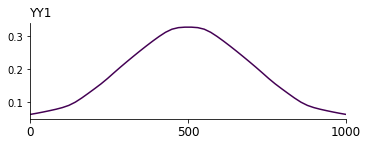

In [13]:
ProfilePack2Visual(YY1_overpeaks, combomode = np.mean, vismode = LinePlot, bounds = (None, None), Vsize = 1000, 
            xlabelsnum = 3, labels = ['YY1'], suptitle = None, figsize = (5,2), fontsize = 12, cmap = 'viridis')

Getting histone signal (4000bp, Vsize = 4000) over the Markers using SigCurrent2Pack. 

In [16]:
#histone_norm = pickle.load(open('histone_norm' + '.p', 'rb'))

histone_overpeaks = SigCurrent2Pack(histone_norm, YY1peaks_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 4000, reso = 20, 
                                    newreso = None, resomode = np.mean, areas = None, exact = True, stranded = True, dtype = np.float32)
histone_overpeaks.shape

(1394, 11, 200)

Averaging the total histone signal(combomode = np.mean) and visualizing with a line plot (vismode = LinePLot). 

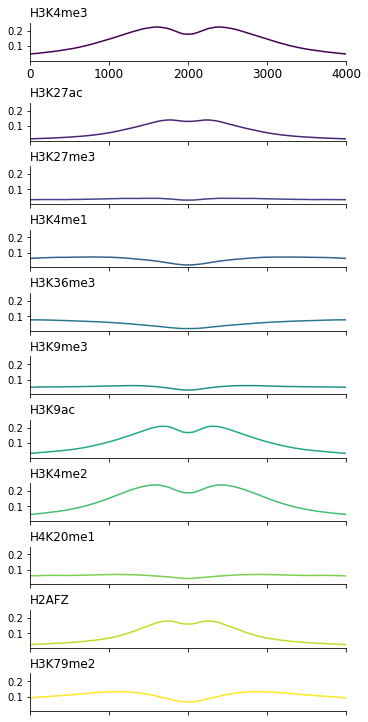

In [18]:
ProfilePack2Visual(histone_overpeaks, combomode = np.mean, vismode = LinePlot, bounds = (None, None), Vsize = 4000, 
                   xlabelsnum = 5, labels = histones, suptitle = None, figsize = (5,10), fontsize = 12, cmap = 'viridis')

### YY1 Potential Interacting Sites

Loading and Converting CM to PWM.  
*See First_steps for pre-work*

In [19]:
YY1_PWM = CM2PWM('YY1_CM.txt', pseudo = True, bkg = [0.25,0.25,0.25,0.25])
YY1_PWM

array([[-0.69632361,  1.27330274, -0.70974413, -1.4970148 ],
       [ 1.92165395, -7.45121111, -2.36374827, -6.45121111],
       [ 1.92816726, -7.45121111, -7.45121111, -2.45121111],
       [ 0.06448873, -0.33227004,  1.0204641 , -2.92764916],
       [ 1.99380373, -7.45121111, -7.45121111, -7.45121111],
       [-7.45121111, -7.45121111, -7.45121111,  1.99380373],
       [-7.45121111, -7.45121111,  1.99380373, -7.45121111],
       [-7.45121111, -7.45121111,  1.99380373, -7.45121111],
       [-1.72329066,  1.78001007, -7.45121111, -1.95935802],
       [-1.77878577, -0.59323012,  1.35291991, -1.02494636],
       [-1.2032836 , -0.97547768,  1.47360139, -1.83650127],
       [-1.2032836 ,  1.53178246, -1.89662226, -1.30146399]])

In [20]:
hg38, hg38_id, hg38_sizes = pickle.load(open('hg38' + '.p', 'rb')) #Loading

Scoring the PWM on the genome SeqCurrent.  
Due to memory constraints, each chr is scored seperately and saved, and each sub-seq is broken to 100 piecies before scoring operations.  
Using multiprocessing (parrellel = 4). 

In [21]:
for c in select_chrs: 
    PWMscores = PWMScorer(YY1_PWM, hg38, hg38_id, [c], parrellel = 4, pieces = 100, extend = True, center = True, dtype = np.float32)
    pickle.dump(PWMscores, open('YY1_PWMscores_' + c + '.p', 'wb')) #Saving
    del PWMscores 

Combining scores from each individual chr to a single Current. 

In [22]:
PWMscores_all = [pickle.load(open('YY1_PWMscores_' + c + '.p', 'rb'))[0] for c in select_chrs]

pickle.dump(PWMscores_all, open('YY1_PWMscores_all' + '.p', 'wb')) #Saving

#### PWM score versus binding intensity

In [15]:
YY1peaks_filt = pickle.load(open('YY1peaks_filt' + '.p', 'rb')) #Loading
PWMscores_all = pickle.load(open('YY1_PWMscores_all' + '.p', 'rb')) #Loading
YY1_norm = pickle.load(open('YY1_norm' + '.p', 'rb')) #Loading

Getting maximum PWM score at each Marker of size 500 with newreso = 500 and resomode of np.max using SigCurrent2Pack. 

In [16]:
YY1peaks_PWM = SigCurrent2Pack(PWMscores_all, YY1peaks_filt, hg38_id, select_BS_ids = select_chrs, Vsize = 500, reso = 1, 
                               newreso = 500, resomode = np.max, areas = None, exact = False, stranded = True, dtype = np.float32)
YY1peaks_PWM.shape

(697, 1, 1)

Flattening the YY1 PWM maximum score pack using PackShaper. 

In [17]:
YY1peaks_PWM_flat = PackShaper(YY1peaks_PWM, expand_dim = None, squeeze = False, twoD = False, flatten = True)
YY1peaks_PWM_flat.shape

(697,)

Finding the correlation of the best PWM score and MACS3 Peak score. 

In [18]:
cor1 = stats.pearsonr(YY1peaks_filt['add4'].values,YY1peaks_PWM_flat)[0]
print(f'Pearson correlation of Peak Score and PWM score: {np.round(cor1, 3)}')

Pearson correlation of Peak Score and PWM score: 0.355


Plotting PWM score vs. Peak Score. 

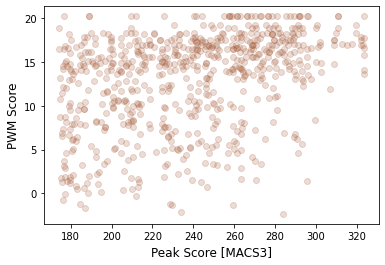

In [19]:
plt.scatter(YY1peaks_filt['add4'].values,YY1peaks_PWM_flat, alpha = 0.2, color = 'sienna');
plt.xlabel('Peak Score [MACS3]', fontsize = fontsize)
plt.ylabel('PWM Score', fontsize = fontsize);

Getting integrated YY1 signal at each Marker of size 480 with Vsize and areas of 480 using SigCurrent2Pack. 

In [28]:
YY1_overpeaks = SigCurrent2Pack(YY1_norm, YY1peaks_filt, hg38_id, select_BS_ids = select_chrs, Vsize = 480, reso = 20, 
                                newreso = None, resomode = np.mean, areas = [480], exact = True, stranded = True, dtype = np.float32)

Flattening the pack using PackShaper. 

In [ ]:
YY1_overpeaks_flat = PackShaper(YY1_overpeaks, expand_dim = None, squeeze = False, twoD = False, flatten = True)

Finding the correlation of the best PWM score and integrated YY1 signal. 

In [ ]:
cor2 = stats.pearsonr(YY1_overpeaks_flat,YY1peaks_PWM_flat)[0]
print(f'Pearson correlation of Peak Score and PWM score: {np.round(cor2, 3)}') 

Plotting PWM score vs. integrated YY1 signal. 

Pearson correlation of Peak Score and PWM score: 0.326


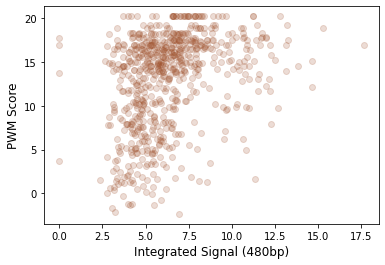

In [29]:
plt.scatter(YY1_overpeaks_flat,YY1peaks_PWM_flat, alpha = 0.2, color = 'sienna');
plt.xlabel('Integrated Signal (480bp)', fontsize = fontsize)
plt.ylabel('PWM Score', fontsize = fontsize);

#### Top PWM sites 

Getting the PWM score flags.  
Loading and modifying each chr seperately for memory constraints.  
PWM scores are first filtered using the full filter Current and multiplying with CurrentModifier.  
Currentthresholder keeps values greater than 0.  
CurrentFlagger finds best value in 200bp window with stride 20 and using double flagging.  

In [31]:
FTE = pickle.load(open('FTE' + '.p', 'rb'))

for ic, c in enumerate(select_chrs): 
    PWMscores = pickle.load(open('YY1_PWMscores_' + c + '.p', 'rb')) #Loading
    PWMscores_filt = CurrentModifier(PWMscores, [FTE[ic]], np.multiply, dtype = np.float32)
    #PWMscores_filt = CurrentThresholder(PWMscores_filt, threshold = 0, threshsign = np.greater, binary = False) #Zeros negative values
    PWMscores_flag = CurrentFlagger(PWMscores_filt, reso = 1, window = 200, stride = 20, flagmode = np.argmax, double = True)
    pickle.dump(PWMscores_flag, open('YY1_PWMscores_flag_' + c + '.p', 'wb')) #Saving
    del PWMscores, PWMscores_filt, PWMscores_flag

In [ ]:
del [FTE] 

Combining flags from each individual chr to a single Current. 

In [32]:
PWMscores_flags = [pickle.load(open('YY1_PWMscores_flag_' + c + '.p', 'rb'))[0] for c in select_chrs]

pickle.dump(PWMscores_flags, open('YY1_PWMscores_flags' + '.p', 'wb')) #Saving

Plotting Histogram of non-zero PWM flags. 

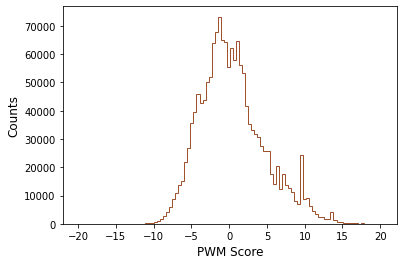

In [33]:
#PWMscores_flags = pickle.load(open('YY1_PWMscores_flags' + '.p', 'rb')) #Loading

flag_values = np.concatenate(PWMscores_flags, axis = 0) #Combining all flag values together for next step

plt.hist(flag_values[flag_values != 0], bins = 100, histtype='step', color = 'sienna');
#plt.title('Cumulative PWM Scores', fontsize = fontsize) 
plt.xlabel('PWM Score', fontsize = fontsize) 
plt.ylabel('Counts', fontsize = fontsize);

In [34]:
del flag_values

Testing different SigCurrent2Markers modes

In [35]:
#PWMscores_flags = pickle.load(open('YY1_PWMscores_flags' + '.p', 'rb')) #Loading

MO = [None, Top, Harpoon, Harpoon, RevDistro, RevDistro, RevDistro, RevDistro]
MA = [None, {'smallest': False}, {'bins': 10}, {'bins': 100}, {'alpha': 0}, {'alpha': 0.5}, {'alpha': 1.0}, {'alpha': 2.0}]

vals = [] 
for im in range(len(MO)): 
    M = SigCurrent2Markers(PWMscores_flags, hg38_id, select_BS_ids = select_chrs, reso = 1, select = 100000, select_mode = MO[im], mode_args = MA[im])
    vals.append(M['val'])

In [36]:
allflags = np.concatenate(PWMscores_flags, axis = 0).reshape(-1)
mi, ma = np.min(allflags), np.max(allflags)
bs = np.linspace(mi, ma, 100)

del allflags

Plotting Markers values for different SigCurrent2Markers modes 

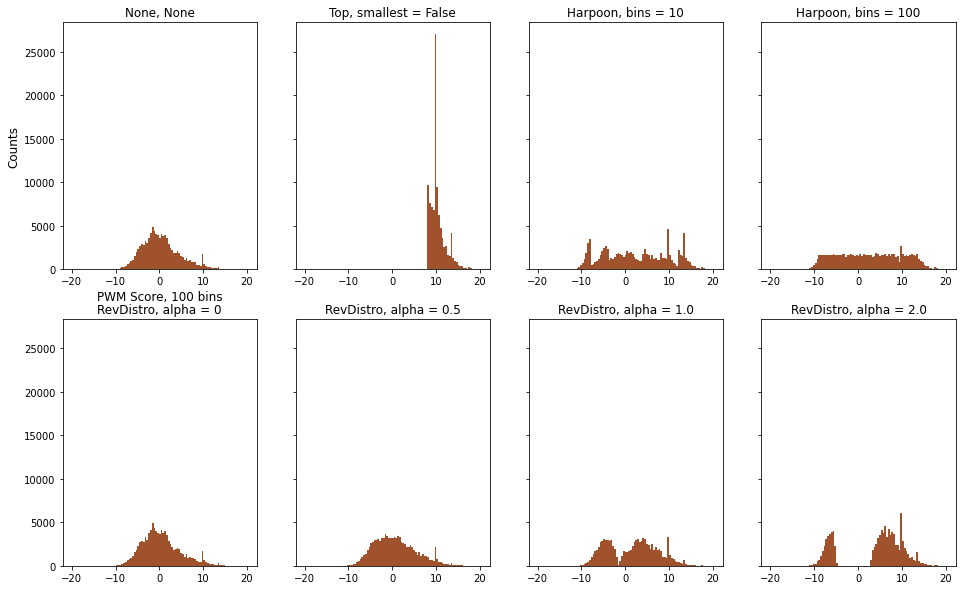

In [37]:
fontsize = 12

sel_modes_names = ['None, None', 'Top, smallest = False', 'Harpoon, bins = 10', 'Harpoon, bins = 100', 
                   'RevDistro, alpha = 0', 'RevDistro, alpha = 0.5', 'RevDistro, alpha = 1.0', 'RevDistro, alpha = 2.0'] 

fig, axs = plt.subplots(2, 4, figsize = (16,10), sharey = True)

for (iv, v), ax in zip(enumerate(vals), axs.ravel()):
    if iv == 0: 
        ax.set_xlabel('PWM Score, 100 bins', fontsize = fontsize)
        ax.set_ylabel('Counts', fontsize = fontsize)
    ax.hist(v, bs, color = 'sienna')
    ax.set_title(sel_modes_names[iv], fontsize = fontsize)

Getting 100,000 Marks from PWM flags with Harpoon (bin = 100) for preparing packs for ML (next step) with SigCurrent2Markers. 

In [38]:
#PWMscores_flags = pickle.load(open('YY1_PWMscores_flags' + '.p', 'rb')) #Loading

PWMscores_harpoon = SigCurrent2Markers(PWMscores_flags, hg38_id, select_BS_ids = select_chrs, reso = 1, select = 100000, select_mode = Harpoon, mode_args = {'bins': 100})

pickle.dump(PWMscores_harpoon, open('YY1_PWMscores_harpoon' + '.p', 'wb'))

PWMscores_harpoon

,subseq,loc,strand,size,val
0,chr1,830276,0,1,1.564099
1,chr1,831773,0,1,-2.718052
2,chr1,847096,0,1,9.274565
3,chr1,847856,0,1,-0.124353
4,chr1,854726,0,1,10.579587
...,...,...,...,...,...
99995,chr3,198060830,0,1,1.363014
99996,chr3,198063371,0,1,4.999675
99997,chr3,198075457,0,1,-5.486622
99998,chr3,198094424,0,1,2.145247


In [ ]:
del [PWMscores_flags] 

### Packs for ML 

Generating Packs for ML using the Harpoon'ed Markers

In [39]:
hg38, hg38_id, hg38_sizes = pickle.load(open('hg38' + '.p', 'rb')) #Loading

PWMscores_harpoon = pickle.load(open('YY1_PWMscores_harpoon' + '.p', 'rb')) #loading 
YY1_norm = pickle.load(open('YY1_norm' + '.p', 'rb')) #Loading
histone_norm = pickle.load(open('histone_norm' + '.p', 'rb')) #Loading

Modifying Markers to be used for pack generation (next steps). Both strands are used (opposite = True) and no marker in the ends of 5000bp. 

In [41]:
PWMscores_ready = Markers4Packs(PWMscores_harpoon, select_BS_ids = None, opposite = True, 
                                 ends = 5000, BS_sizes = hg38_sizes, BS_ids = hg38_id)

Integrated YY1 signal of 480bp over Markers. 

In [42]:
YY1pack = SigCurrent2Pack(YY1_norm, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 480, reso = 20, 
                          newreso = None, resomode = np.mean, areas = [480], exact = True, stranded = True, dtype = np.float32)

Flattening pack, likely to be used for Sklearn. 

In [ ]:
YY1pack_flat = PackShaper(YY1pack, expand_dim = None, squeeze = False, twoD = False, flatten = True)

Histone signal of 4000bp over Markers. 

In [ ]:
histonepack_profile = SigCurrent2Pack(histone_norm, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 4000, reso = 20, 
                                      newreso = 100, resomode = np.mean, areas = None, exact = True, stranded = True, dtype = np.float32)

print(f'Histone ProfilePack shape: {histonepack_profile.shape}')

Integrated Histone signals (4) with maximum of 4000bp over Markers. 

In [43]:
areas = np.geomspace(500,4000,4, dtype = int) #Getting different 4 areas from 500 to 4000bp geometrically. 
histonepack_areas= SigCurrent2Pack(histone_norm, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 4000, reso = 20, 
                                   newreso = None, resomode = np.mean, areas = areas, exact = True, stranded = True, dtype = np.float32)

print(f'Histone AreasPack shape: {histonepack_areas.shape}')

Histone ProfilePack shape: (200000, 11, 40)
Histone AreasPack shape: (200000, 11, 4)


Also getting the best PWM score over each Marker with Traits2Pack. 

In [11]:
PWMscore_pack = Traits2Pack(PWMscores_ready, cols = 4, vectorize = None)
PWMscore_pack.shape

(200000,)

Getting sequences underlying Markers of size 500, stranded (stranded = True) with SeqCurrent2Pack. 

In [44]:
seq_pack = SeqCurrent2Pack(hg38, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 500, seqmode = None, stranded = True)

Getting sequences underlying Markers of size 500, stranded (stranded = True), and OHE (seqmode = Seqs2OHE) with SeqCurrent2Pack. 

In [45]:
seq_pack_OHE = SeqCurrent2Pack(hg38, PWMscores_ready, hg38_id, select_BS_ids = select_chrs, Vsize = 500, seqmode = Seqs2OHE, stranded = True)
seq_pack_OHE.shape

(200000, 500, 4)

Combinations of packs can be done with Packs2Pack([Packs]) 

#### Splitting Packs

Splits for ML are generated using Splits and the Markers.  
3 Splits are generated (numsplits = 3) with simple Train Test split of 0.7 and 0.3 proportions, respecively (proportions = [0.7,0.3]).  
The cut method is applied (cut = True) 

In [48]:
YY1sites_split = Splitter(len(PWMscores_ready), numsplits = 3, proportions = [0.7, 0.3], random = False, cut = True)


YY1sites_split[0]

[array([ 34263,  34264,  34265, ..., 174260, 174261, 174262]),
 array([174263, 174264, 174265, ...,  34260,  34261,  34262])]

Splitting a pack by a split can be done with PackSplit(Pack, YY1sites_split[n])